# Process metadata CSV

In [1]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import joblib
import torch
import torchvision.transforms as T
from config import config
from src.utils.model_factory import get_model
from src.models.hyperparameters import params
from itertools import tee
import matplotlib.pyplot as plt

/Users/antoine/miniconda3/envs/skin-cbir/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../backend-project/data/HAM10000_metadata.csv")

---
## Populate with latent space coordinates

In [5]:
input_dim = params[config['model']]['input_dim']
batch_size = params[config['model']]['batch_size']
transform = T.Compose([T.Resize((input_dim, input_dim)), T.ToTensor()])
model_path = '/home/jimmy/Medical1-xai-iml22/LightningVAE/reports/logs/20220513-033014_BetaVAEConv/epoch=61-step=9734.ckpt'
file_dir = 'data/HAM10000/images'
pretrained_model = get_model(params[config['model']], config['model'], f'')
pretrained_model = pretrained_model.load_from_checkpoint(model_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jimmy/Medical1-xai-iml22/LightningVAE/reports/logs/20220513-033014_BetaVAEConv/epoch=61-step=9734.ckpt'

In [4]:
file_names = df['image_id'].tolist()
file_names = [f'{name}.jpg' for name in file_names]

In [5]:
len(file_names)

10015

In [22]:
from PIL import Image
import re
import os
from torch.utils.data import Dataset

#TODO
file_names = df['image_id'].tolist()
file_names = [f'{name}.jpg' for name in file_names]

class PredictDataset(Dataset):
    '''
    Class to represent our dataset of XRay images. Subclass of torch.utils.data.Dataset. Store the image directory,
    images name, bounding boxes and data of the images we will use either for training or testing.
    '''

    def __init__(self, img_dir, images_name, transform=None):
        self.img_dir = img_dir
        # Read all the names of the PNG files in the directory
        images_dir = np.array([name for name in os.listdir(img_dir) if
                                os.path.isfile(os.path.join(img_dir, name)) and
                                (re.search('png$', name) is not None or re.search('jpg$', name) is not None)])
        print(len(images_name))
        for i in images_name:
            if i not in images_dir:
                raise Exception(f'{i} not contained')
        self.images_name = np.array(images_name)
        self.transform = transform
    def __len__(self):
        '''
        Overload: return the length of the dataset

        Return
        ----------
        length: înt:
            The length of the dataset
        '''
        return self.images_name.shape[0]

    def __getitem__(self, idx):

        img_path = os.path.join(self.img_dir, self.images_name[idx])
        img = Image.open(img_path)
        if self.transform:
            image = self.transform(img)
        return image

In [23]:
from torch.utils.data import DataLoader

dataset = PredictDataset(file_dir, file_names, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

10015


In [30]:
import torch

In [32]:
l = []
with torch.no_grad():
    for X in dataloader:
        mu, _ = pretrained_model.encoder(X)
        l.append(mu)

In [33]:
print(l[0].size())
print(len(l))
print(l[-1].size())

torch.Size([32, 12])
313
torch.Size([31, 12])


In [34]:
encodings = np.zeros((len(file_names), 12))
for i, enc in enumerate(l):
    encodings[i*batch_size:i*batch_size+len(enc), :] = enc

In [37]:
encodings[:, 0]

array([-0.10697883,  0.70565534,  0.38071865, ...,  1.94463515,
       -0.25017375, -0.41401255])

In [39]:
for i in range(encodings.shape[1]):
    df[f'latent_coordinate_{i}'] = encodings[:, i]

In [40]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,latent_coordinate_0,latent_coordinate_1,latent_coordinate_2,latent_coordinate_3,latent_coordinate_4,latent_coordinate_5,latent_coordinate_6,latent_coordinate_7,latent_coordinate_8,latent_coordinate_9,latent_coordinate_10,latent_coordinate_11
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,-0.106979,-0.048668,-0.419150,0.194135,-2.685104,-0.646395,1.056195,0.102851,-0.075413,-0.154920,-2.428411,-0.919434
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.705655,0.050683,-1.023222,-1.391752,-2.161137,-0.309022,0.167083,0.219867,-0.377357,0.104617,-3.011379,0.209624
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.380719,0.255320,-0.056129,0.226035,-2.525144,-0.196947,0.511622,0.802484,-0.511810,-0.258092,-2.620443,-0.472238
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.472043,-0.137823,-0.361311,-1.125323,-1.433660,-0.167007,-0.444764,0.336240,-0.732898,-0.483380,-2.758510,0.212307
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,-0.720086,1.370297,-3.048022,2.123658,-2.115688,3.325147,0.345185,-1.395048,-1.391270,0.426988,-2.219423,-3.214153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0.580097,1.080211,0.927477,1.666362,-2.240172,-1.216325,1.467841,-0.382297,-0.222215,0.473341,-1.748961,-2.263403
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,1.320278,1.106107,-0.339287,-0.923631,-1.780693,-0.817924,1.168669,0.801686,-0.374658,-0.274085,-1.614189,0.593689
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,1.944635,1.640213,-0.844746,0.630668,-3.794259,-1.452682,1.977639,0.475680,-0.996336,-0.159440,-2.523479,-1.017225
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,-0.250174,0.256625,-0.078109,0.267487,-2.249359,0.657497,0.084284,0.249557,0.099993,0.045181,-1.498652,-1.212404


---
## Populate with UMAP coordinates, and save UMAP model

In [2]:
df = pd.read_csv("../backend-project/data/HAM10000_latent_space_processed.csv")

In [3]:
latent_coordinates = df[['latent_coordinate_' + str(i) for i in range(12)]]

In [4]:
COLOR_MAP = {
    "akiec" : "b",
    "bcc" : "g",
    "bkl" : "r",
    "df" : "c",
    "mel" : "m",
    "nv" : "y",
    "vasc" : "k"
}


In [5]:
def draw_umap(n_neighbors=15, min_dist=0.1, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric=metric
    )
    u = fit.fit_transform(latent_coordinates)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(u[:,0], u[:,1], s=1, c=[COLOR_MAP[dx] for dx in df['dx']], alpha=0.3)
    plt.title(title, fontsize=18)

/Users/antoine/miniconda3/envs/skin-cbir/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/antoine/miniconda3/envs/skin-cbir/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/antoine/miniconda3/envs/skin-cbir/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Users/antoine/miniconda3/envs/skin-c

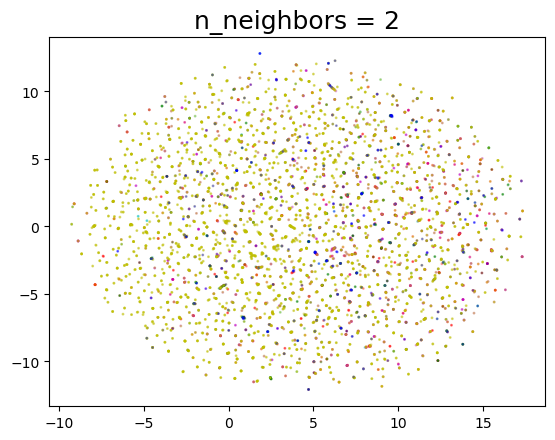

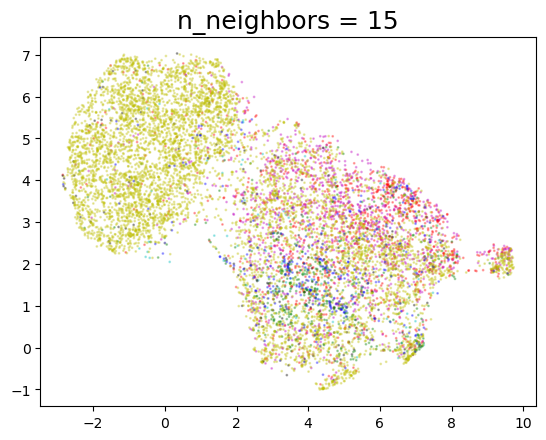

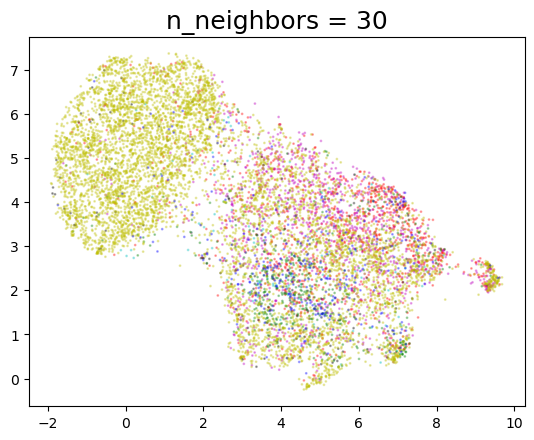

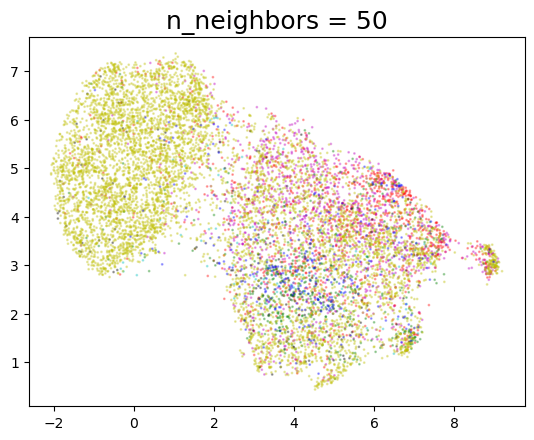

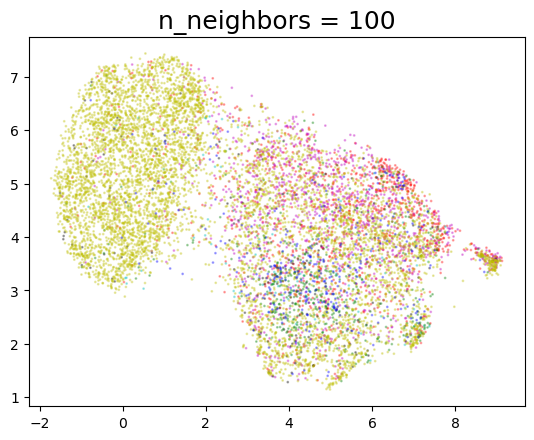

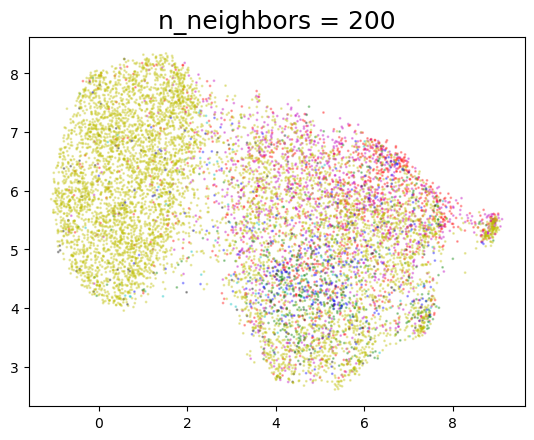

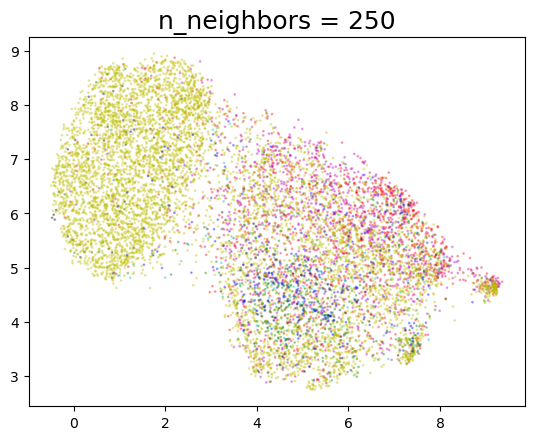

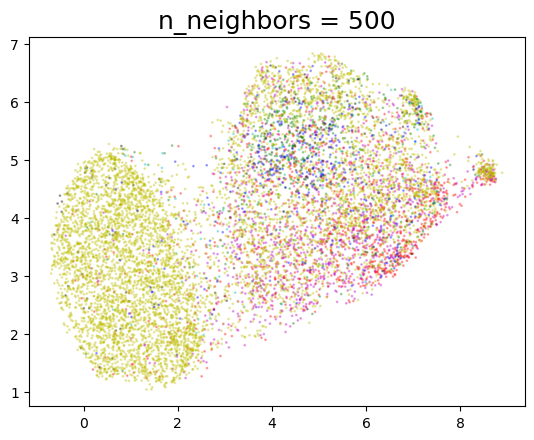

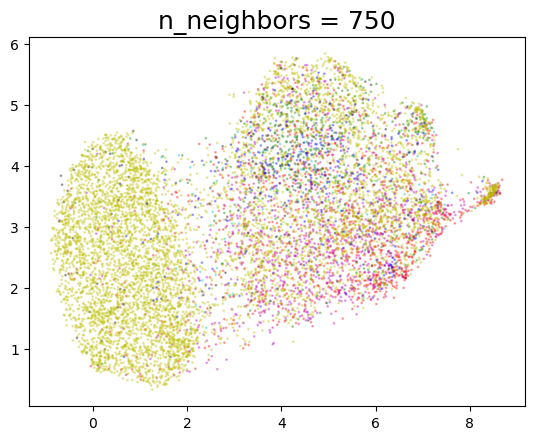

In [7]:
for n in (2, 15, 30, 50, 100, 200, 250, 500, 750):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

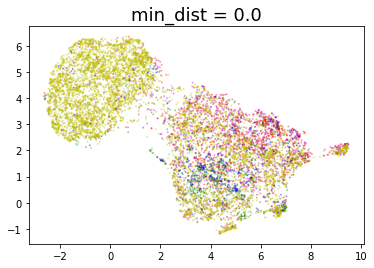

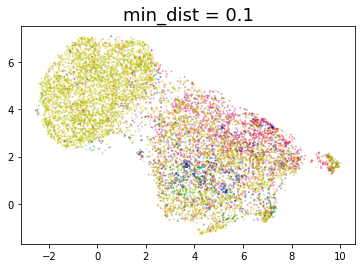

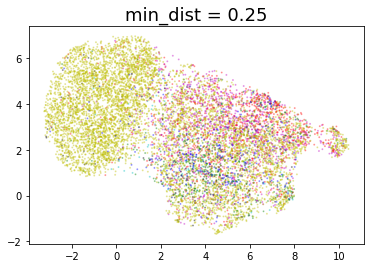

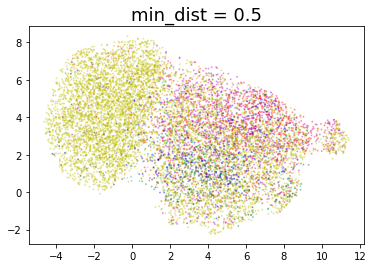

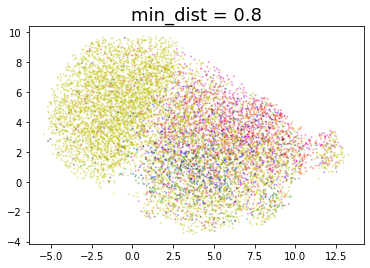

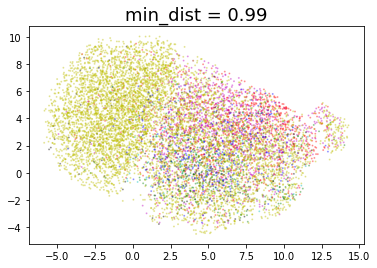

In [29]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [5]:
# Fit UMAP model
import umap.umap_ as umap
reducer = umap.UMAP(random_state=0, n_neighbors=15, min_dist=0)
reducer = reducer.fit(latent_coordinates)

In [6]:
# Serialize UMAP model
joblib.dump(reducer, "../backend-project/data/umap.sav")

['../backend-project/data/umap.sav']

In [7]:
# Get UMAP coordinates
embeddings = reducer.transform(latent_coordinates)
df["umap1"] = embeddings[:,0]
df["umap2"] = embeddings[:,1] 

---
## Save CSV

In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,latent_coordinate_0,latent_coordinate_1,latent_coordinate_2,...,latent_coordinate_4,latent_coordinate_5,latent_coordinate_6,latent_coordinate_7,latent_coordinate_8,latent_coordinate_9,latent_coordinate_10,latent_coordinate_11,umap1,umap2
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,-0.106979,-0.048668,-0.419150,...,-2.685104,-0.646395,1.056195,0.102851,-0.075413,-0.154920,-2.428411,-0.919434,4.342072,0.958916
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.705655,0.050683,-1.023222,...,-2.161137,-0.309022,0.167083,0.219867,-0.377357,0.104617,-3.011379,0.209624,7.305955,0.572881
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.380719,0.255320,-0.056129,...,-2.525144,-0.196947,0.511622,0.802484,-0.511810,-0.258092,-2.620443,-0.472238,4.423264,1.271363
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.472043,-0.137823,-0.361311,...,-1.433660,-0.167007,-0.444764,0.336240,-0.732898,-0.483380,-2.758510,0.212307,7.324741,0.769176
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,-0.720086,1.370297,-3.048022,...,-2.115688,3.325147,0.345185,-1.395048,-1.391270,0.426988,-2.219423,-3.214153,2.893228,3.097783


In [9]:
df.to_csv("../backend-project/data/HAM10000_latent_space_umap_processed.csv", index=False)